# Elastic wave equation implementation on a staggered grid

This second elastic tutorial extends the previous constant parameter implementation to varying parameters (Lame parameters) and takes advantage of the Tensorial capabilities of Devito to write the elastic wave equation following its mathematical definition. The staggering is automated via the TensorFunction API.

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic import plot_image, demo_model
import numpy as np

import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

# Some ploting setup
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

In [2]:
#NBVAL_IGNORE_OUTPUT
# Initial grid: 3km x 3km, with spacing 10m
nlayers = 5
model = demo_model(preset='layers-elastic', nlayers=nlayers, shape=(301, 301), spacing=(10., 10.))

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


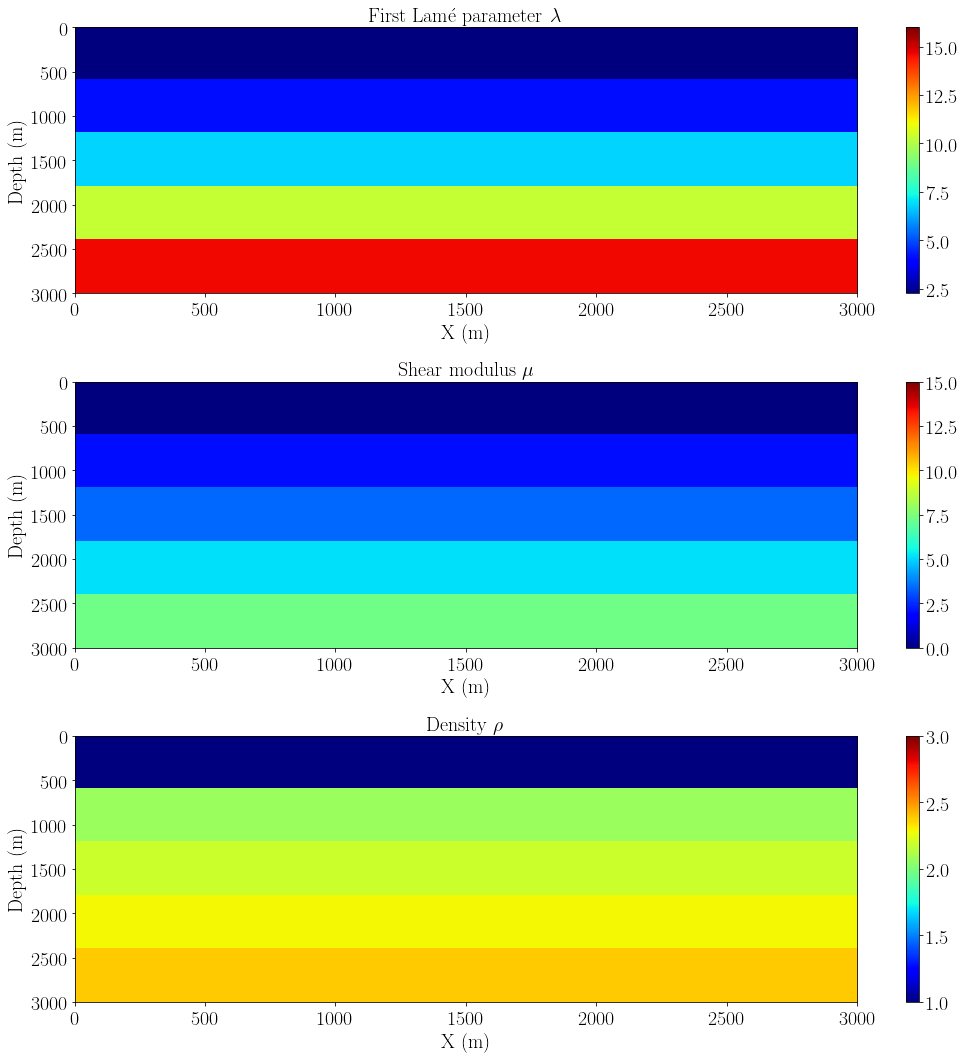

In [3]:
#NBVAL_SKIP
aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0], model.origin[0] + model.domain_size[0],
                                               model.origin[1] + model.domain_size[1], model.origin[1]]}
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

img1 = ax[0].imshow(np.transpose(model.lam.data[slices]), vmin=1.5**2, vmax=4.0**2, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"First Lam\'e parameter $\lambda$", fontsize=20)
ax[0].set_xlabel('X (m)', fontsize=20)
ax[0].set_ylabel('Depth (m)', fontsize=20)
ax[0].set_aspect('auto')


img2 = ax[1].imshow(np.transpose(model.mu.data[slices]), vmin=0, vmax=15, **plt_options_model)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title(r"Shear modulus $\mu$", fontsize=20)
ax[1].set_xlabel('X (m)', fontsize=20)
ax[1].set_ylabel('Depth (m)', fontsize=20)
ax[1].set_aspect('auto')


img3 = ax[2].imshow(1/np.transpose(model.b.data[slices]), vmin=1.0, vmax=3.0, **plt_options_model)
fig.colorbar(img3, ax=ax[2])
ax[2].set_title(r"Density $\rho$", fontsize=20)
ax[2].set_xlabel('X (m)', fontsize=20)
ax[2].set_ylabel('Depth (m)', fontsize=20)
ax[2].set_aspect('auto')


plt.tight_layout()

In [4]:
# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 2000.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=model.grid, f0=0.015, time_range=time_range)
src.coordinates.data[:] = [1500., 10.]

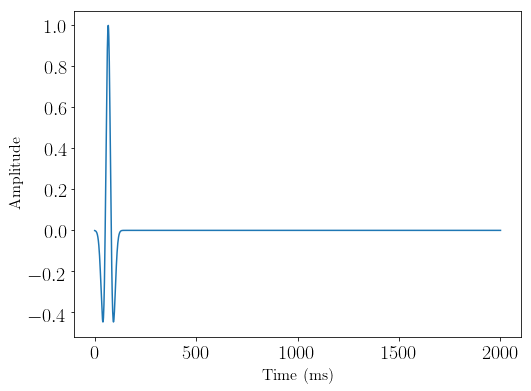

In [5]:
#NBVAL_SKIP

src.show()

# Vectorial form

While conventional litterature writes the elastic wave-equation as a set of scalar PDEs, the higher level representation comes from Hooke's law and the equation of motion and writes as:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = \lambda tr(\nabla v) \mathbf{I}  + \mu (\nabla v + (\nabla v)^T)
\end{cases}

and as $tr(\nabla v)$ is the divergence of $v$ we can reqrite it as

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = \lambda \text{diag}(\nabla . v) + \mu (\nabla v + (\nabla v)^T)
\end{cases}

where $v$ is a vector valued function:

$v(t, x, y) = (v_x(t, x, y), v_y(t, x, y)$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y) = \begin{bmatrix}\tau_{xx}(t, x, y) & \tau_{xy}(t, x, y)\\\tau_{xy}t, x, y) & \tau_{yy}(t, x, y)\end{bmatrix}$


We show in the following how to setup the elastic wave-equation form Devito's high-level tensorial types.

In [6]:
# Now we create the velocity and pressure fields
so = 8

x, z = model.grid.dimensions
t = model.grid.stepping_dim
time = model.grid.time_dim
s = time.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

In [7]:
# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
src_zz = src.inject(field=tau.forward[1, 1], expr=s*src)

# The receiver
nrec = 301
rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec.coordinates.data[:, -1] = 5.

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec2.coordinates.data[:, -1] = 3000.0/nlayers

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec3.coordinates.data[:, -1] = 3000.0/nlayers

rec_term = rec.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term += rec2.interpolate(expr=v[1])
rec_term += rec3.interpolate(expr=v[0])

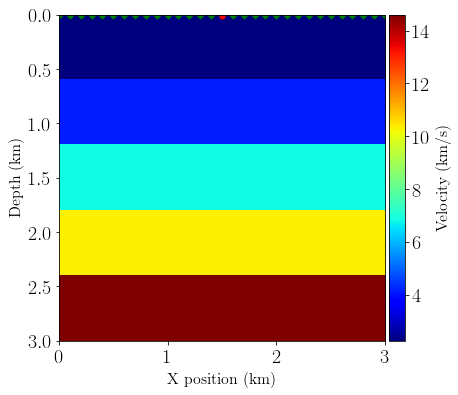

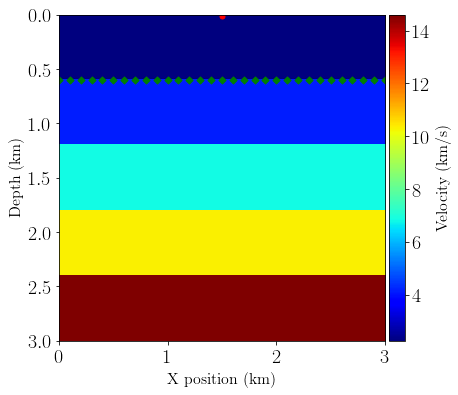

In [8]:
#NBVAL_SKIP
from examples.seismic import plot_velocity
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::10, :])
plot_velocity(model, source=src.coordinates.data,
              receiver=rec2.coordinates.data[::10, :])

In [9]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# fdelmodc reference implementation
u_v = Eq(v.forward, model.damp * (v + s*ro*div(tau)))
u_t = Eq(tau.forward,  model.damp *  (tau + s * (l * diag(div(v.forward)) +
                                                mu * (grad(v.forward) + grad(v.forward).T))))

op = Operator([u_v] + [u_t] + src_xx + src_zz + rec_term)

In [10]:
v._time_order

1

In [11]:
ro._eval_at(v[0]).evaluate

0.5⋅b(x, y) + 0.5⋅b(x + hₓ, y)

We can now see that both the particle velocities and stress equations are vectorial and tensorial equations. Devito takes care of the discretization and staggered grids automatically for these types of object.

In [12]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y), v_y(t + dt, x, y + h_y/2)), Vector((dt*(Derivative(t_xx(t, x, y), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2), y))*b(x, y) + v_x(t, x + h_x/2, y))*damp(x, y), (dt*(Derivative(t_xy(t, x + h_x/2, y + h_y/2), x) + Derivative(t_yy(t, x, y), y))*b(x, y) + v_y(t, x, y + h_y/2))*damp(x, y)))

In [13]:
u_t

Eq(SymmetricTensor( t_xx(t + dt, x, y), t_xy(t + dt, x + h_x/2, y + h_y/2), t_yy(t + dt, x, y),), Tensor( (dt*((Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_x(t + dt, x + h_x/2, y), x)) + t_xx(t, x, y))*damp(x, y), (dt*(Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2))*damp(x, y), (dt*(Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2))*damp(x, y), (dt*((Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_y(t + dt, x, y + h_y/2), y)) + t_yy(t, x, y))*damp(x, y),))

In [14]:
#NBVAL_IGNORE_OUTPUT
# Partial ru for 1.2sec to plot the wavefield
op(dt=model.critical_dt, time_M=int(1000/model.critical_dt))

Operator `Kernel` run in 1.12 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=0.9892909999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.05067399999999986, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.027636000000000063, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.024220999999999993, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section4', rank=None),
  PerfEntry(time=0.01932999999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

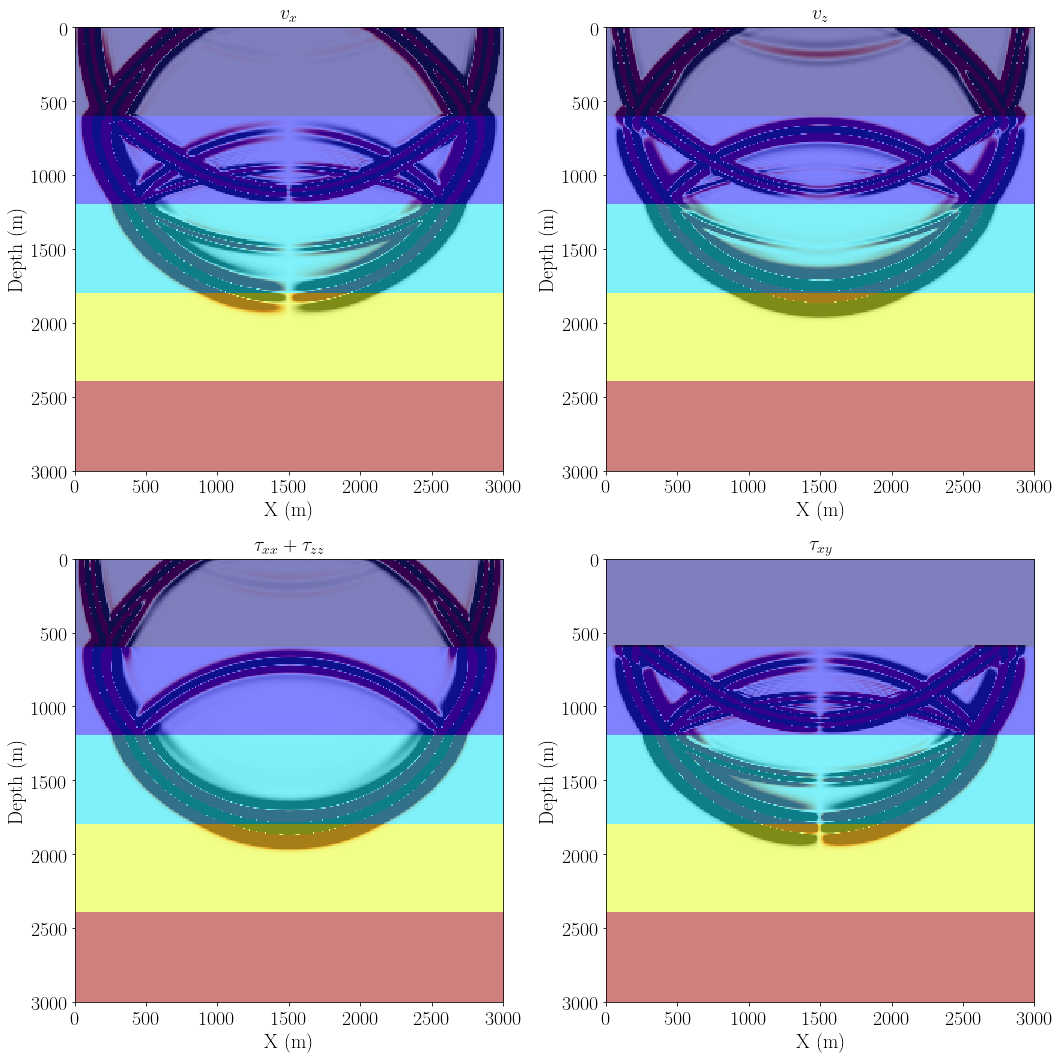

In [15]:
#NBVAL_SKIP
scale = .5*1e-3

plt_options_model = {'extent': [model.origin[0] , model.origin[0] + model.domain_size[0],
                                model.origin[1] + model.domain_size[1], model.origin[1]]}


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax[0, 0].imshow(np.transpose(v[0].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
ax[0, 0].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[0, 0].set_aspect('auto')
ax[0, 0].set_xlabel('X (m)', fontsize=20)
ax[0, 0].set_ylabel('Depth (m)', fontsize=20)
ax[0, 0].set_title(r"$v_{x}$", fontsize=20)

ax[0, 1].imshow(np.transpose(v[1].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
ax[0, 1].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[0, 1].set_aspect('auto')
ax[0, 1].set_title(r"$v_{z}$", fontsize=20)
ax[0, 1].set_xlabel('X (m)', fontsize=20)
ax[0, 1].set_ylabel('Depth (m)', fontsize=20)

ax[1, 0].imshow(np.transpose(tau[0,0].data[0][slices]+tau[1,1].data[0][slices]),
             vmin=-10*scale, vmax=10*scale, cmap="RdGy", **plt_options_model)
ax[1, 0].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet",
               alpha=.5, **plt_options_model)
ax[1, 0].set_aspect('auto')
ax[1, 0].set_title(r"$\tau_{xx} + \tau_{zz}$", fontsize=20)
ax[1, 0].set_xlabel('X (m)', fontsize=20)
ax[1, 0].set_ylabel('Depth (m)', fontsize=20)


ax[1, 1].imshow(np.transpose(tau[0,1].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
ax[1, 1].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[1, 1].set_aspect('auto')
ax[1, 1].set_title(r"$\tau_{xy}$", fontsize=20)
ax[1, 1].set_xlabel('X (m)', fontsize=20)
ax[1, 1].set_ylabel('Depth (m)', fontsize=20)


plt.tight_layout()

In [16]:
#NBVAL_IGNORE_OUTPUT
# Full run for the data
op(dt=model.critical_dt, time_m=int(1000/model.critical_dt))

Operator `Kernel` run in 1.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=0.8772489999999987, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.07094000000000245, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.0228589999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.01211600000000015, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section4', rank=None),
  PerfEntry(time=0.035921999999999704, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [17]:
# Data on a standard 2ms tim axis
rec_plot = rec.resample(num=1001)
rec2_plot = rec2.resample(num=1001)
rec3_plot = rec3.resample(num=1001)

In [18]:
scale_for_plot = np.diag(np.linspace(1.0, 2.5, 1001)**2.0)

Text(0.5, 0, 'Receiver position (m)')

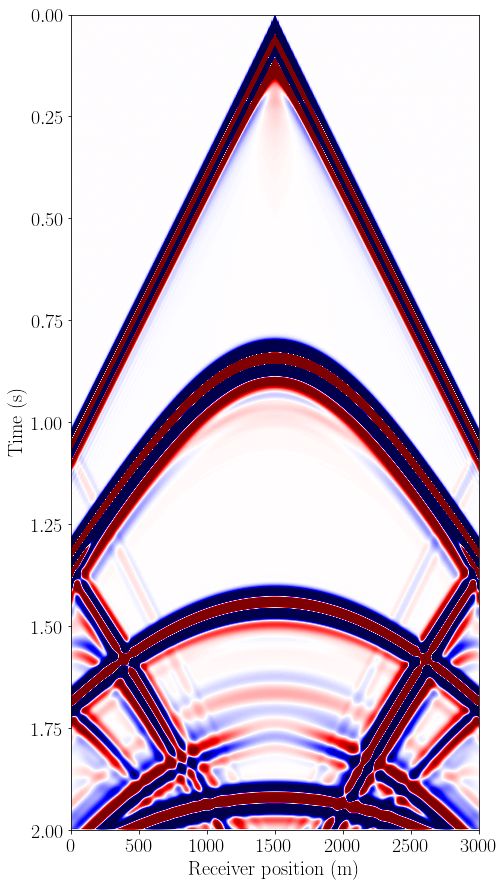

In [19]:
#NBVAL_SKIP
# Pressure (txx + tzz) data at sea surface
extent = [rec_plot.coordinates.data[0, 0], rec_plot.coordinates.data[-1, 0], 1e-3*tn, t0]
aspect = rec_plot.coordinates.data[-1, 0]/(1e-3*tn)/.5

plt.figure(figsize=(15, 15))
plt.imshow(np.dot(scale_for_plot, rec_plot.data), vmin=-.01, vmax=.01, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)


Text(0.5, 0, 'Receiver position (m)')

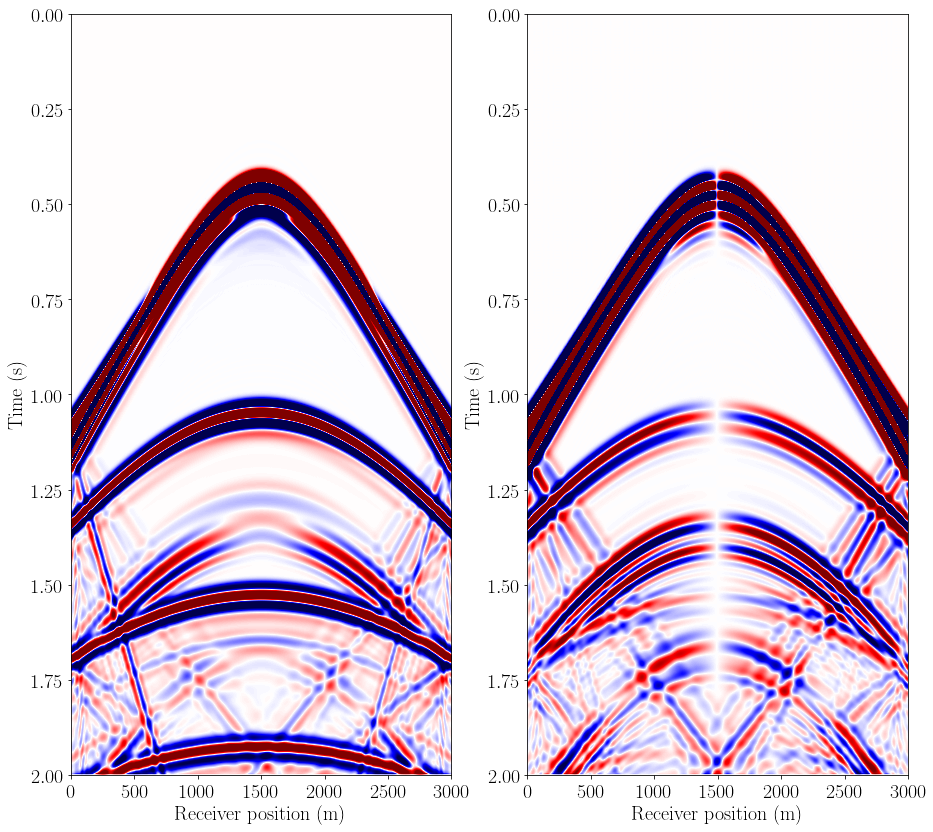

In [20]:
#NBVAL_SKIP
# OBC data of vx/vz
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(rec2_plot.data, vmin=-1e-3, vmax=1e-3, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)
plt.subplot(122)
plt.imshow(rec3_plot.data, vmin=-1e-3, vmax=1e-3, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)

In [21]:
# Now that looks pretty! But let's do it again with a 2nd order in time
so = 8
v2 = VectorTimeFunction(name='v2', grid=model.grid, space_order=so, time_order=2)
tau0 = TensorFunction(name='t0', grid=model.grid, space_order=so)
# The source injection term
src_xx = src.inject(field=tau0[0, 0], expr=src.dt)
src_zz = src.inject(field=tau0[1, 1], expr=src.dt)

s = model.grid.time_dim.spacing
# fdelmodc reference implementation
u_v = Eq(v2.forward, model.damp * (2 * v2 - model.damp * v2.backward + s**2*ro*div(tau0)))
u_t = Eq(tau0, model.damp * (l * diag(div(v2.forward)) + mu * (grad(v2.forward) + grad(v2.forward).T)))


# rec_term = rec.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term = rec2.interpolate(expr=v2[0])
rec_term += rec3.interpolate(expr=v2[1])
op = Operator([u_v] + [u_t] + src_xx + src_zz + rec_term)


In [22]:
#NBVAL_IGNORE_OUTPUT
# Partial ru for 1.2sec to plot the wavefield
op(dt=model.critical_dt, time_M=int(1000/model.critical_dt))

Operator `Kernel` run in 1.16 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=1.0576629999999994, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.023192000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.035976000000000084, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.035476000000000014, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

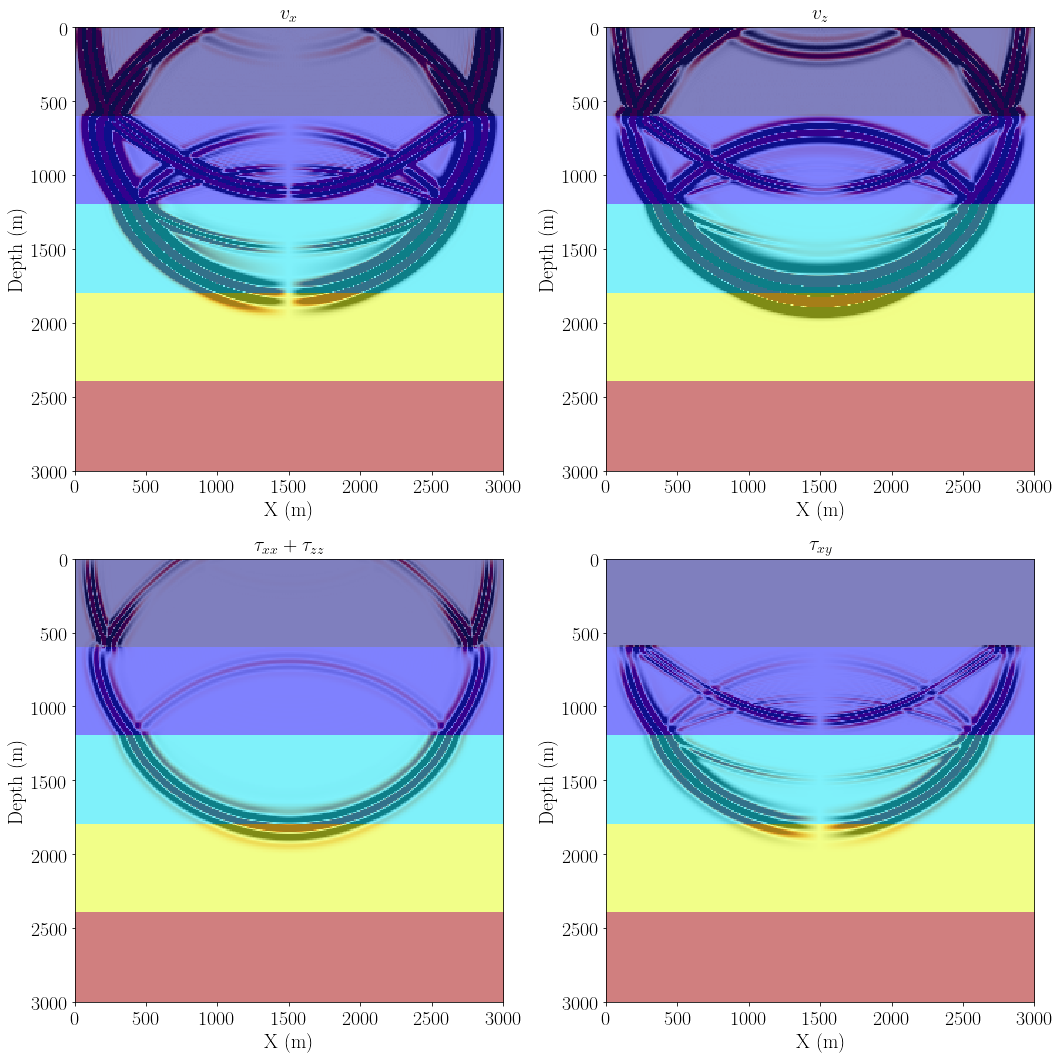

In [23]:
#NBVAL_SKIP
scale = 1e-4

plt_options_model = {'extent': [model.origin[0] , model.origin[0] + model.domain_size[0],
                                model.origin[1] + model.domain_size[1], model.origin[1]]}


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax[0, 0].imshow(np.transpose(v2[0].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
ax[0, 0].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[0, 0].set_aspect('auto')
ax[0, 0].set_xlabel('X (m)', fontsize=20)
ax[0, 0].set_ylabel('Depth (m)', fontsize=20)
ax[0, 0].set_title(r"$v_{x}$", fontsize=20)

ax[0, 1].imshow(np.transpose(v2[1].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
ax[0, 1].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[0, 1].set_aspect('auto')
ax[0, 1].set_title(r"$v_{z}$", fontsize=20)
ax[0, 1].set_xlabel('X (m)', fontsize=20)
ax[0, 1].set_ylabel('Depth (m)', fontsize=20)

ax[1, 0].imshow(np.transpose(tau0[0,0].data[slices]+tau0[1,1].data[slices]),
             vmin=-10*scale, vmax=10*scale, cmap="RdGy", **plt_options_model)
ax[1, 0].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet",
               alpha=.5, **plt_options_model)
ax[1, 0].set_aspect('auto')
ax[1, 0].set_title(r"$\tau_{xx} + \tau_{zz}$", fontsize=20)
ax[1, 0].set_xlabel('X (m)', fontsize=20)
ax[1, 0].set_ylabel('Depth (m)', fontsize=20)


ax[1, 1].imshow(np.transpose(tau0[0,1].data[slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
ax[1, 1].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[1, 1].set_aspect('auto')
ax[1, 1].set_title(r"$\tau_{xy}$", fontsize=20)
ax[1, 1].set_xlabel('X (m)', fontsize=20)
ax[1, 1].set_ylabel('Depth (m)', fontsize=20)


plt.tight_layout()

In [24]:
#NBVAL_IGNORE_OUTPUT
op(dt=model.critical_dt, time_m=int(1000/model.critical_dt))

Operator `Kernel` run in 0.63 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=0.5995209999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.004740000000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.009282999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.0071569999999999785, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [25]:
rec2_plot2 = rec2.resample(num=1001)
rec3_plot2 = rec3.resample(num=1001)

Text(0.5, 0, 'Receiver position (m)')

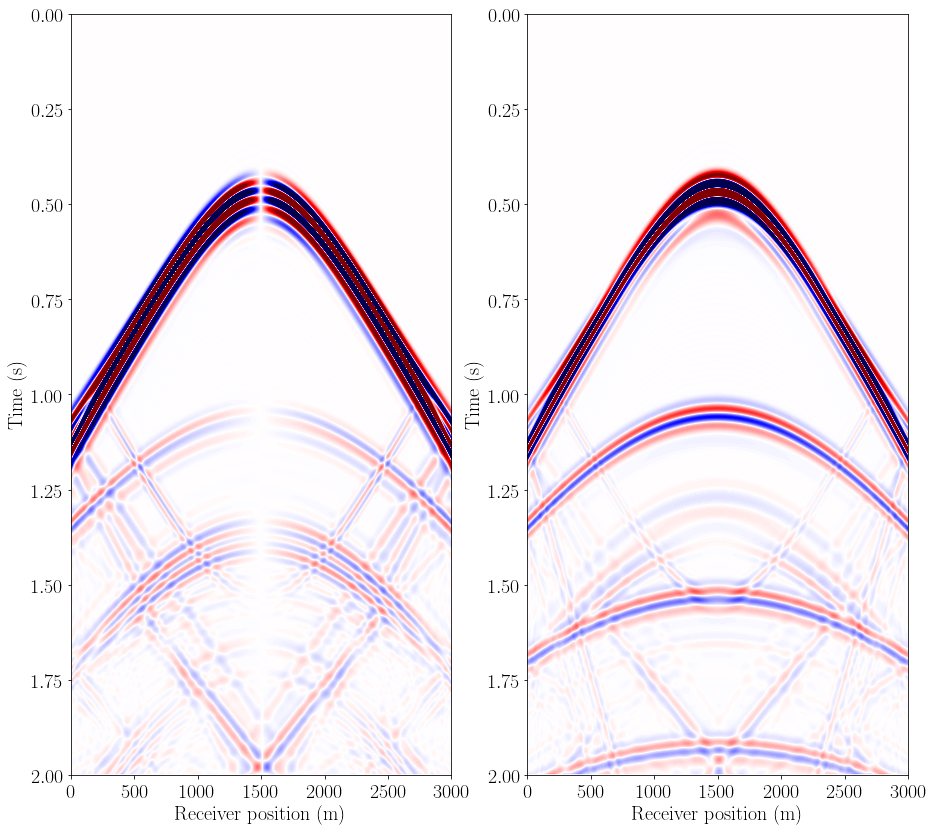

In [26]:
#NBVAL_SKIP
# OBC data of vx/vz
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(rec2_plot2.data, vmin=-1e-3, vmax=1e-3, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)
plt.subplot(122)
plt.imshow(rec3_plot2.data, vmin=-1e-3, vmax=1e-3, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)